# Проект по теме "Введение в машинное обучение"

# Поиск и выбор модели для рекомендации подходящего тарифа сотовой связи

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

**Цели и задачи:** 
- Построить модель для задачи классификации, которая выберет подходящий тариф
- Постройте модель с максимально большим значением accuracy (не менее 0.75). 
- Проверьте accuracy на тестовой выборке самостоятельно.

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.
<br/>**Описание данных:**
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откройте и изучите файл

Подключаем библиотеки:

- pandas - для работы с таблицами
- seaborn и matplotlib - для визуализации данных
- sklearn - инструменты машинного обучения (модели классификации, метрики для исследования качества моделей, разделение данных на тренировочные, валидационные, тестовые выборки)

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

Загрузим данные из файла users_behavior.csv, выведем первые 10 строк таблицы для первого взгляда на данные.
Также с помощью метода info() изучим структуру таблицы: типы данных, количество строк, столбцов, пропущенных данных.

In [91]:
data = pd.read_csv('/datasets/users_behavior.csv')
display(data.head(10))
data.info()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Видим, что в колонках calls и mesasges значения целочисленные (т.к. в данных по задаче нам сказано, что calls и messages это колонки с количеством звонков и сообщений), поэтому заменим их с float на int.

In [92]:
data['calls'] = data['calls'].astype('int64')
data['messages'] = data['messages'].astype('int64')

Посмотрим на наш датасет через метод describe

In [93]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Видим вполне адекватные значения, в т.ч. медианы и среднего, которые в данном случае друг от друга не сильно отличаются, что означает, что данные немного скошены.

Посмотрим, как распределены данные на гистограмме и "ящике с усами"

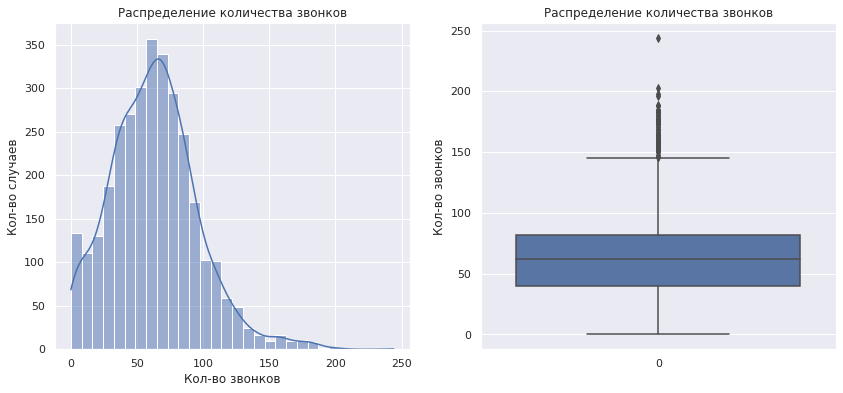

In [94]:
sns.set_theme()
f, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].set_title('Распределение количества звонков')
axes[0].set_xlabel('Кол-во звонков')
axes[0].set_ylabel('Кол-во случаев')
sns.histplot(data['calls'], bins=30, kde=True, ax=axes[0])
axes[1].set_title('Распределение количества звонков')
sns.boxplot(data=data['calls'], ax=axes[1])
axes[1].set_ylabel('Кол-во звонков')
plt.show()

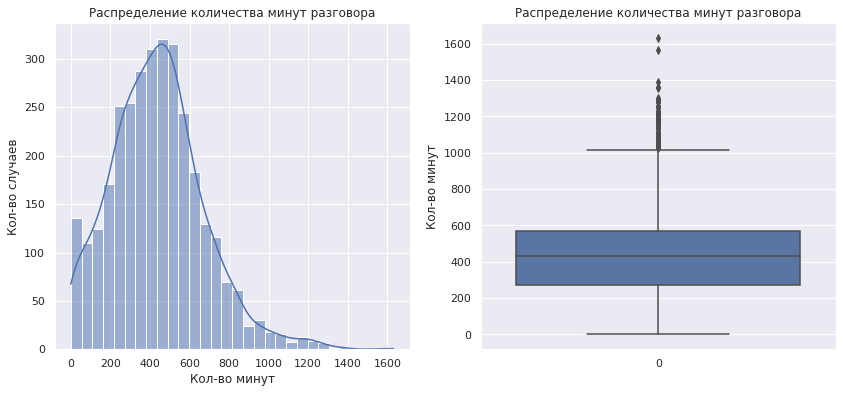

In [95]:
sns.set_theme()
f, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].set_title('Распределение количества минут разговора')
axes[0].set_xlabel('Кол-во минут')
axes[0].set_ylabel('Кол-во случаев')
sns.histplot(data['minutes'], bins=30, kde=True, ax=axes[0])
axes[1].set_title('Распределение количества минут разговора')
sns.boxplot(data=data['minutes'], ax=axes[1])
axes[1].set_ylabel('Кол-во минут')
plt.show()

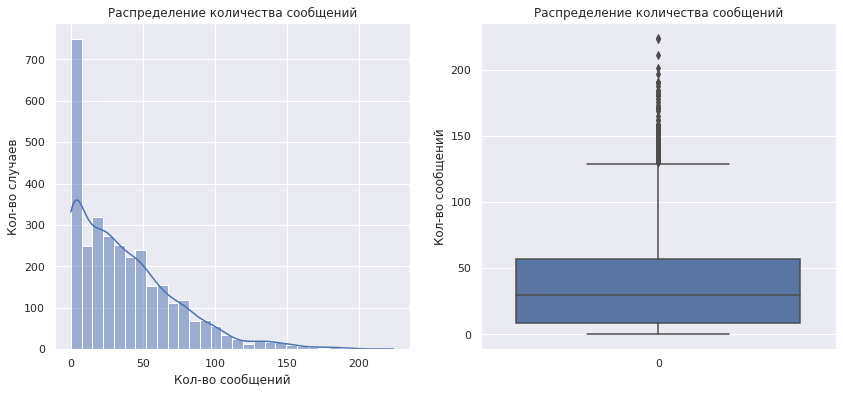

In [96]:
sns.set_theme()
f, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].set_title('Распределение количества сообщений')
axes[0].set_xlabel('Кол-во сообщений')
axes[0].set_ylabel('Кол-во случаев')
sns.histplot(data['messages'], bins=30, kde=True, ax=axes[0])
axes[1].set_title('Распределение количества сообщений')
sns.boxplot(data=data['messages'], ax=axes[1])
axes[1].set_ylabel('Кол-во сообщений')
plt.show()

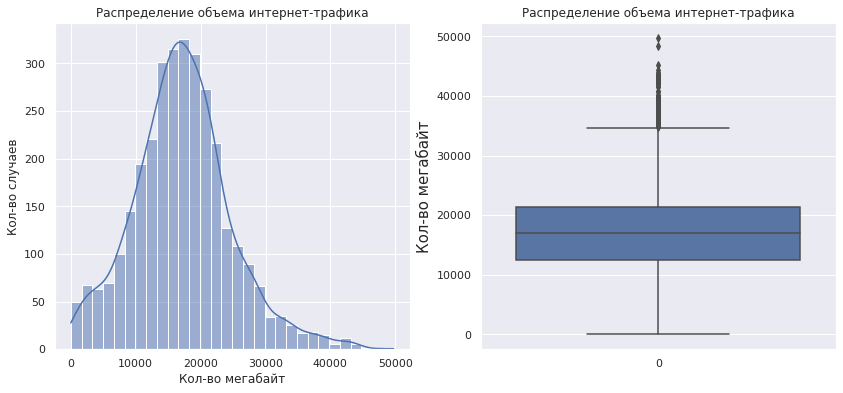

In [97]:
sns.set_theme()
f, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].set_title('Распределение объема интернет-трафика')
axes[0].set_xlabel('Кол-во мегабайт')
axes[0].set_ylabel('Кол-во случаев')
sns.histplot(data['mb_used'], bins=30, kde=True, ax=axes[0])
axes[1].set_title('Распределение объема интернет-трафика')
sns.boxplot(data=data['mb_used'], ax=axes[1])
axes[1].set_ylabel('Кол-во мегабайт', fontsize=15)
plt.show()

Здесь мы видим, что данные распределены более-менее нормально, в колонке messages есть скос влево, т.к. много нулевых значений.

## Разбейте данные на выборки

Для начала выделим в исходных данных:
- признаки: calls, minutes, messages, mb_used
- целевой признак: is_ultra

In [98]:
features = data.drop('is_ultra', axis=1)
target = data['is_ultra']

Разделим данные на обучающую, валидационную и тестовую выборки в пропорции 60% на обучающию и по 20% данных на валидационную и тестовую выборки.

In [99]:
X, X_test, y, y_test = train_test_split(features, target, test_size=0.2, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

## Исследуйте модели

### Решающее дерево

Первым выберем решающее дерево, проверим лучшую его глубину

In [100]:
best_model = None
best_result = 0
for depth in range(1, 10):
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth) # обучите модель с заданной глубиной дерева
    model_dt.fit(X_train, y_train) # обучите модель
    predictions = model_dt.predict(X_valid) # получите предсказания модели
    result = accuracy_score(y_valid, predictions) # посчитайте качество модели
    if result > best_result:
        best_model = model_dt
        best_result = result
        
print('Accuracy лучшей модели:', best_result)
print('Лучшая модель', best_model)

Accuracy лучшей модели: 0.7844660194174757
Лучшая модель DecisionTreeClassifier(max_depth=5, random_state=12345)


### Случайный лес

Случайный лес

In [101]:
best_model = None
best_result = 0
for nest in range(1,10):
    for max_depth in range(1,10):
        model_rf = RandomForestClassifier(random_state=12345, n_estimators=nest, max_depth=max_depth)
        model_rf.fit(X_train, y_train)
        result = model_rf.score(X_valid, y_valid)
        if result > best_result:
            best_model = model_rf
            best_result = result

print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print('Лучшая модель', best_model)

Accuracy наилучшей модели на валидационной выборке: 0.8097087378640777
Лучшая модель RandomForestClassifier(max_depth=7, n_estimators=9, random_state=12345)


### Логистическая регрессия

Инициируем модель логистической регрессии LogisticRegression
Критерием проверки качества модели будет точность accuracy.

In [102]:
model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=10000)
model_lr.fit(X_train, y_train)
predictions = model_lr.predict(X_valid)
result = accuracy_score(y_valid, predictions)
print(model_lr)
print("Accuracy модели на валидационной выборке:", result)

LogisticRegression(max_iter=10000, random_state=12345)
Accuracy модели на валидационной выборке: 0.6990291262135923


## Проверьте модель на тестовой выборке

По критерию accuracy наилучшей точности удалось достичь с моделью Случайного леса
- Наилучшая точность: 0.81
- Парамтеры модели: n_estimators = 10
- max_depth = 9
- min_samples_split = 6
- min_samples_leaf = 2
- criterion = gini
Проведём обучение данной модели на всех доступных данных (обучающие + валидационные) и вычислим точность на тестовой выборке.

In [103]:
model_rf_clf = RandomForestClassifier(random_state=123,
                                      n_estimators=10,
                                      max_depth=9)
model_rf_clf.fit(X, y)
predictions = model_rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print('Точность модели на тестовой выборке:', round(accuracy, 2))

Точность модели на тестовой выборке: 0.82


Вывод:

Были проанализированы различные классификационные модели: Решающее дерево, Случайный лес, Логистическая регрессия.
Каждая модель была обучена для различных сочетаний гиперпараметров (кроме логистической регрессии); выведены наилучшие варианты для каждой модели.
Наилучшая точность (accuracy) была достигнута для модели Случайного леса:
Accuracy на валидационной выборке: 0.82
Accuracy на тестовой выборке: 0.82

# Общий вывод

1) Данные успешно загружены и проанализированы.
- Пропусков не обнаружено, типы данных преобразованы в соответствии с хранимой информацией.
- Сильного перекоса в распределениях признаков не наблюдается.

<br>2) Были проанализированы различные классификационные модели: Решающее дерево, Случайный лес, Логистическая регрессия. Модели обучены на различных сочетаниях гиперпараметров (кроме логистической регрессии).
- Наилучшая точность (accuracy) была достигнута для модели Случайного леса: Accuracy на тестовой выборке: 0.82

# <font color='orange'>Общее впечатление</font>
* Этот проект выполнен очень хорошо
* Видно, что приложено много усилий
* Молодец, что структурируешь ноутбук, приятно проверять такие работы
* У тебя чистый и лаконичный код
* Мне было интересно читать твои промежуточные выводы
* Твой уровень подачи материала находится на высоком уровне
* Критических замечаний нет
* Молодец, отличная работа!
* Удачи в дальнейшем обучении 👋

# <font color='orange'>Рекомендации 🔥</font>
* Анализ данных на python и pandas https://www.youtube.com/watch?v=dd3RcafdOQk&t=82s
* Как обучается Дерево решений https://www.youtube.com/watch?v=j8L07nuns2Y
* Случайный лес https://www.youtube.com/watch?v=EhJPSV-Jr_0
* Линейная регрессия https://www.youtube.com/watch?v=QZJ94igWVxQ&t=49s
* Логистическая регрессия https://www.youtube.com/watch?v=49ck7kCyxr4
* Курс "Введение в машинное обучение" https://stepik.org/course/4852
* В нашем деле нужно быть всегда в курсе всех новинок, новостей и тд, вот тут публикуют новости в области DS: https://www.infoq.com/data-analysis/news/
* Всем аналитикам данных рекомендую книгу Даниела Канемана "Думай медленно, решай быстро"